In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pylab import *

In [2]:
df= pd.read_pickle("../data/clean_rows_df.pkl")  
df.head()

,VoltageCurve,CurrentCurve,spotName
TimeStamp,,,
2019-11-07 12:29:06,"[132, 744, 1299, 1663, 1894, 2002, 2068, 2110,...","[311, 1990, 3577, 4759, 5599, 6190, 6594, 6999...",60000_0_00
2019-11-07 12:29:26,"[136, 752, 1308, 1675, 1923, 2068, 2128, 2180,...","[301, 1961, 3470, 4527, 5432, 6066, 6489, 6911...",60000_0_00
2019-11-07 12:29:26,"[139, 757, 1292, 1655, 1885, 2042, 2099, 2099,...","[333, 2058, 3663, 4814, 5661, 6388, 6842, 7084...",60000_0_00
2019-11-07 12:29:30,"[133, 743, 1286, 1645, 1887, 2046, 2104, 2104,...","[307, 2031, 3632, 4802, 5695, 6434, 6865, 7142...",60000_0_00
2019-11-07 12:29:32,"[137, 755, 1313, 1683, 1906, 2043, 2147, 2189,...","[302, 1995, 3508, 4596, 5382, 5987, 6562, 6955...",60000_0_00


In [3]:
#Voltage_df=df.drop("CurrentCurve", axis=1)
#Current_df=df.drop("VoltageCurve", axis=1)

In [4]:
df.reset_index(inplace=True)
df.set_index(["spotName","TimeStamp"],inplace=True)

In [5]:
exploded_voltage=pd.DataFrame(df.VoltageCurve.tolist(), index= df.index)

In [6]:
#quali dati hanno la massima numerosità (624) di raccolte
#exploded_voltage[exploded_voltage[623].notna()].head()
#per selezionare la prima riga
#exploded_voltage.iloc[0]
#oppure
#exploded_voltage.loc[("60000_0_00","2019-11-07 12:29:06")]

## Analisi esplorativa su exploded_voltage
Da grafico delle slide (da ricreare) si nota come molte curve abbiano un calo improvviso: voglio escluderle dal calcolo della curva media che userò come riferimento.

<AxesSubplot:>

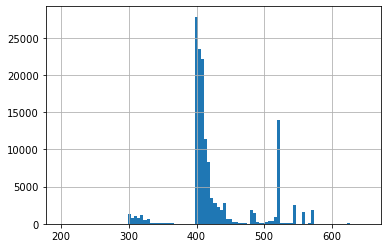

In [7]:
exploded_voltage.count(axis=1).hist(bins=100,range=(200,650))

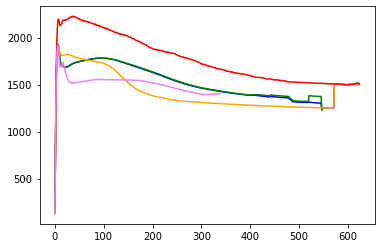

In [8]:
#plotto la curva media di tutti i valori
plot(exploded_voltage.mean(axis=0),"blue")
#plotto la curva media delle sole curve con meno di 500 rilevazioni
plot(exploded_voltage[exploded_voltage.count(axis=1)<550].mean(axis=0),"green")
#plotto la curva media delle sole curve con più di 500 rilevazioni
plot(exploded_voltage[exploded_voltage.count(axis=1)>550].mean(axis=0),"orange")
#plotto la curva media delle sole curve con più di 600 rilevazioni
plot(exploded_voltage[exploded_voltage.count(axis=1)>600].mean(axis=0),"red")
#plotto la curva media delle sole curve con più di 600 rilevazioni
plot(exploded_voltage[exploded_voltage.count(axis=1)<340].mean(axis=0),"violet")

è interessante notare l'andamento delle curve sulla base della numerosità delle rilevazioni fatte:
-   curve con più di 600 o meno di 300 rilevazioni sono chiaramente delle anomalie

## Approccio statistico

Voglio identificare, attraverso un approoccio statistico del differenziale, quelle curve che hanno avuto un picco (o un calo) improvviso della tensione, per cui risulta un anomalia strutturale della curva stessa.
Attraverso diversi tentativi e verifiche grafiche si è optato per un differenziale di quinto ordine, attraverso cui si riesce a cogliere il picco di tensione

In [41]:
#calcolo il differenziale tra valori successivi 
voltage_lag5=exploded_voltage.diff(periods=5,axis=1)
#voltage_lag5.mean(axis=0).head(20)

In [42]:
#creazione upper e lower limit come per Normale (mean +- 2*std)
upper_lag=voltage_lag5.apply(lambda x : x.mean()+4*x.std(),axis=0)
lower_lag=voltage_lag5.apply(lambda x : x.mean()-4*x.std(),axis=0)
#creazione upper e lower usando i quantili
upper_lag2=voltage_lag5.apply(lambda x : x.quantile(0.75)+1.5*(x.quantile(0.75)-x.quantile(0.25)),axis=0)
lower_lag2=voltage_lag5.apply(lambda x : x.quantile(0.25)-1.5*(x.quantile(0.75)-x.quantile(0.25)),axis=0)

Esempio di detection di un calo di tensione

[]

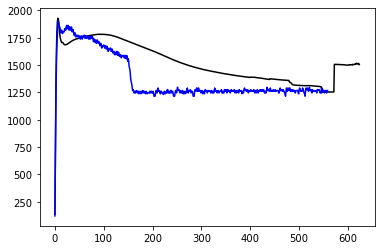

In [11]:
# voltaggio medio tra tutte le curve
plot(exploded_voltage.mean(axis=0),"black")
#plot(exploded_voltage.iloc[20],"green")
plot(exploded_voltage.iloc[590],"blue")
plot()

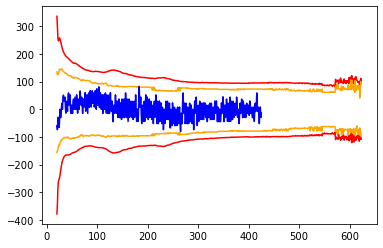

In [43]:
# plot dei differenziali e relativi range di ammissibilità
plt.plot(upper_lag[20:],"red")
plt.plot(upper_lag2[20:],"orange")
plt.plot(voltage_lag5.iloc[10][20:],"blue")
plt.plot(lower_lag2[20:],"orange")
plt.plot(lower_lag[20:],"red")

Seleziono solo i dati che non mostrano cali di tensione

In [ ]:
upper_lag=voltage_lag5.apply(lambda x : x.mean()+4*x.std(),axis=0)

In [44]:
#per poter verificare se i valori rientrano o meno nelle soglie stabilite devo trattare i Null
#sostituisco i Null in voltage_lag5 con 0 
voltage_lag5=voltage_lag5.fillna(0)

#sostituisco i Null in upper_lag con 500
upper_lag=upper_lag.fillna(500)
#sostituisco i Null in lower_lag con -500
lower_lag=lower_lag.fillna(-500)

In [50]:
#abbiamo valori superiori al limite?
any(voltage_lag5.iloc[20]>upper_lag)

False

In [51]:
#abbiamo valori inferiori al limite?
any(voltage_lag5.iloc[20]<lower_lag)

True

## Anomaly detection per singoli punti
Non conosciamo la distribuzione che i dati assumono nei vari istanti temporali (anche se data la numerosità potremmo assumere una distribuzione normale). Definiamo gli outlier come:
-   The data points which fall below mean-3*(sigma) or above mean+3*(sigma) [adatta a norm]
-   The data points which fall below Q1 – 1.5 IQR or above Q3 + 1.5 IQR [adatta per dist asimettriche]

In [32]:
#creazione upper e lower limit come per Normale (mean +- 2*std:al 95%,mean +- 3*std:al 99% )
upper_limit=exploded_voltage.apply(lambda x : x.mean()+2*x.std(),axis=0)
lower_limit=exploded_voltage.apply(lambda x : x.mean()-2*x.std(),axis=0)

In [33]:
#creazione upper e lower usando i quantili
upper_limit2=exploded_voltage.apply(lambda x : x.quantile(0.75)+1.5*(x.quantile(0.75)-x.quantile(0.25)),axis=0)
lower_limit2=exploded_voltage.apply(lambda x : x.quantile(0.25)-1.5*(x.quantile(0.75)-x.quantile(0.25)),axis=0)

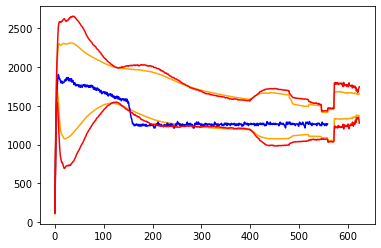

In [36]:
#plottiamo i limiti per vedere come si comportano (in arancio limiti con la std, in rosso con i percentili)
plot(upper_limit,"orange")
plot(lower_limit,"orange")
plot(exploded_voltage.iloc[590],"blue")
plot(upper_limit2,"red")
plot(lower_limit2,"red")